<a href="https://colab.research.google.com/github/philBram/tensorflow/blob/main/food_101_dataset_conv_net_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hansgntermayer","key":"5396338d1f2e946610e16e17106b13de"}'}

In [3]:
import os.path

if not os.path.exists('../root/.kaggle'):
  !mkdir ~/.kaggle
  !mv kaggle.json ~/.kaggle
  !chmod 600 ~/.kaggle/kaggle.json

In [4]:
if not os.path.exists('food41.zip'):
  !kaggle datasets download kmader/food41
  !unzip -qo food41.zip -d food41

Dataset URL: https://www.kaggle.com/datasets/kmader/food41
License(s): copyright-authors
100% 5.30G/5.30G [04:23<00:00, 20.1MB/s]
100% 5.30G/5.30G [04:23<00:00, 21.6MB/s]


In [5]:
for root, dirs, files in os.walk('food41'):
  print(f'{len(dirs)} dirictories and {len(files)} files in "{root}"')

2 dirictories and 11 files in "food41"
1 dirictories and 0 files in "food41/meta"
0 dirictories and 6 files in "food41/meta/meta"
101 dirictories and 0 files in "food41/images"
0 dirictories and 1000 files in "food41/images/miso_soup"
0 dirictories and 1000 files in "food41/images/tacos"
0 dirictories and 1000 files in "food41/images/ravioli"
0 dirictories and 1000 files in "food41/images/spring_rolls"
0 dirictories and 1000 files in "food41/images/gyoza"
0 dirictories and 1000 files in "food41/images/bruschetta"
0 dirictories and 1000 files in "food41/images/caprese_salad"
0 dirictories and 1000 files in "food41/images/caesar_salad"
0 dirictories and 1000 files in "food41/images/beet_salad"
0 dirictories and 1000 files in "food41/images/shrimp_and_grits"
0 dirictories and 1000 files in "food41/images/steak"
0 dirictories and 1000 files in "food41/images/grilled_salmon"
0 dirictories and 1000 files in "food41/images/spaghetti_carbonara"
0 dirictories and 1000 files in "food41/images/lo

In [6]:
!ls food41/images/fried_rice | head

1004221.jpg
1008935.jpg
1015700.jpg
1019981.jpg
1021229.jpg
1022515.jpg
1023430.jpg
1028159.jpg
1028939.jpg
1042399.jpg


In [7]:
!ls -la food41/meta/meta

total 4148
drwxr-xr-x 2 root root    4096 May 11 13:48 .
drwxr-xr-x 3 root root    4096 May 11 13:48 ..
-rw-r--r-- 1 root root    1184 Sep 20  2019 classes.txt
-rw-r--r-- 1 root root    1184 Sep 20  2019 labels.txt
-rw-r--r-- 1 root root  566868 Sep 20  2019 test.json
-rw-r--r-- 1 root root  489429 Sep 20  2019 test.txt
-rw-r--r-- 1 root root 1697751 Sep 20  2019 train.json
-rw-r--r-- 1 root root 1468812 Sep 20  2019 train.txt


In [8]:
import json

def get_labels(label_path):

  with open(label_path) as f:
    return json.load(f)

train_labels = get_labels('food41/meta/meta/train.json')
test_labels = get_labels('food41/meta/meta/test.json')

In [9]:
list(train_labels.keys())[:10]

['churros',
 'hot_and_sour_soup',
 'samosa',
 'sashimi',
 'pork_chop',
 'spring_rolls',
 'panna_cotta',
 'beef_tartare',
 'greek_salad',
 'foie_gras']

In [10]:
train_labels['fried_rice'][:10]

['fried_rice/1004221',
 'fried_rice/1008935',
 'fried_rice/1015700',
 'fried_rice/1019981',
 'fried_rice/1021229',
 'fried_rice/1022515',
 'fried_rice/1043851',
 'fried_rice/1052689',
 'fried_rice/1053345',
 'fried_rice/1059042']

In [11]:
len(train_labels['fried_rice']), len(test_labels['fried_rice'])

(750, 250)

In [12]:
def create_dir_structure(first_class, second_class):
  root_dir = 'food-101'

  train_dir = os.path.join(root_dir, 'train')
  test_dir = os.path.join(root_dir, 'test')

  first_class_train_dir = os.path.join(train_dir, first_class)
  first_class_test_dir = os.path.join(test_dir, first_class)

  second_class_train_dir = os.path.join(train_dir, second_class)
  second_class_test_dir = os.path.join(test_dir, second_class)

  if not os.path.exists('food-101'):
    os.makedirs(first_class_train_dir)
    os.makedirs(first_class_test_dir)
    os.makedirs(second_class_train_dir)
    os.makedirs(second_class_test_dir)

In [13]:
first_class = 'fried_rice'
second_class = 'french_fries'

create_dir_structure(first_class, second_class)

In [14]:
for root, dirs, files in os.walk('food-101'):
  print(f'{len(dirs)} dirictories and {len(files)} files in "{root}"')

2 dirictories and 0 files in "food-101"
2 dirictories and 0 files in "food-101/train"
0 dirictories and 0 files in "food-101/train/fried_rice"
0 dirictories and 0 files in "food-101/train/french_fries"
2 dirictories and 0 files in "food-101/test"
0 dirictories and 0 files in "food-101/test/fried_rice"
0 dirictories and 0 files in "food-101/test/french_fries"


In [15]:
import shutil

def copy_images(labels, method):
  first_class_labels = labels[first_class]
  second_class_labels = labels[second_class]

  src_dir = f'food41/images/'
  dest_dir = 'food-101/train' if method == 'train' else 'food-101/test'

  for label in np.hstack([first_class_labels, second_class_labels]):

    shutil.copy(os.path.join(src_dir, label + '.jpg'), os.path.join(dest_dir, label + '.jpg'))

In [16]:
copy_images(train_labels, 'train')
copy_images(test_labels, 'test')

In [17]:
for root, dirs, files in os.walk('food-101'):
  print(f'{len(dirs)} dirictories and {len(files)} files in "{root}"')

2 dirictories and 0 files in "food-101"
2 dirictories and 0 files in "food-101/train"
0 dirictories and 750 files in "food-101/train/fried_rice"
0 dirictories and 750 files in "food-101/train/french_fries"
2 dirictories and 0 files in "food-101/test"
0 dirictories and 250 files in "food-101/test/fried_rice"
0 dirictories and 250 files in "food-101/test/french_fries"


In [18]:
import cv2

def plot_random_images(row=3, col=3, train=True):

  dir_name = 'food-101/train/' if train else 'food-101/test/'

  fig, ax = plt.subplots(row, col, figsize=(8, 6))
  fig.suptitle('train images', fontsize=18) if train else fig.suptitle('test images', fontsize=18)

  first_class_images_path = [os.path.join(dir_name, first_class, img_path) for img_path in os.listdir(dir_name + first_class)]
  second_class_images_path = [os.path.join(dir_name, second_class, img_path) for img_path in os.listdir(dir_name + second_class)]

  images_path = np.hstack([first_class_images_path, second_class_images_path])

  random_image_choices = np.random.choice(images_path, row * col, replace=False)

  example_img = cv2.imread(random_image_choices[0])
  height, width = example_img.shape[:2]

  for i in range(row * col):
    i_index = i // col
    j_index = i % col

    image = cv2.imread(random_image_choices[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))

    ax[i_index, j_index].axis('off')
    ax[i_index, j_index].set_title(first_class if first_class in random_image_choices[i] else second_class)
    ax[i_index, j_index].imshow(image)

  plt.tight_layout()
  plt.show()

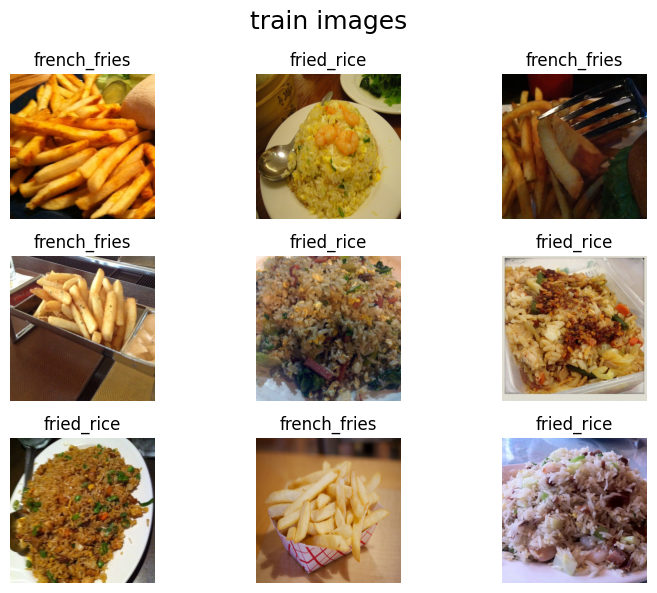

In [19]:
plot_random_images()

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'food-101/train'
val_dir = 'food-101/test'

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=90,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               (256, 256),
                                               class_mode='binary',
                                               batch_size=32)

val_data = val_datagen.flow_from_directory(val_dir,
                                           (256, 256),
                                           class_mode='binary',
                                           batch_size=32,
                                           shuffle=False)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [21]:
def plot_datagen_images(row=3, col=3, train=True):
  image_names = train_data.filenames if train else val_data.filenames
  random_image_choices = np.random.choice(image_names, row * col)

  plt.figure(figsize=(8, 6))
  plt.suptitle('train images', fontsize=(18)) if train else plt.suptitle('test images', fontsize=(18))

  for i in range(row * col):

    plt.subplot(row, col, i + 1)

    image_path = f'food-101/train/{random_image_choices[i]}' if train else f'food-101/test/{random_image_choices[i]}'

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))

    plt.title(random_image_choices[i].split('/')[0])
    plt.imshow(image)
    plt.axis('off')

  plt.tight_layout()
  plt.show()

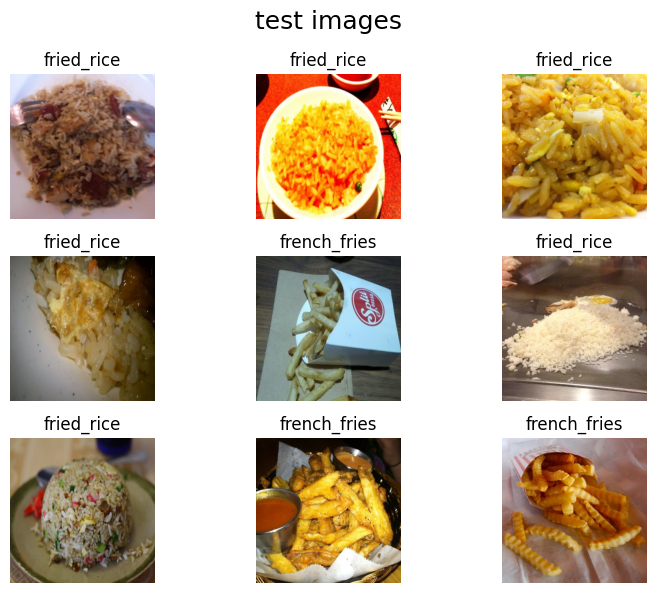

In [22]:
plot_datagen_images(train=False)

In [30]:
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr if (epoch + 1) % 5 != 0 else lr * np.exp(-0.1))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_data, steps_per_epoch=len(train_data), validation_data=val_data,
                    validation_steps=len(val_data), epochs=30, callbacks=[lr_decay_callback])

Epoch 1/30
47/47 [==============================] - 29s 589ms/step - loss: 0.6532 - accuracy: 0.5973 - val_loss: 0.5458 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 2/30
47/47 [==============================] - 28s 595ms/step - loss: 0.5649 - accuracy: 0.7307 - val_loss: 0.5217 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 3/30
47/47 [==============================] - 28s 604ms/step - loss: 0.5395 - accuracy: 0.7340 - val_loss: 0.4626 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 4/30
47/47 [==============================] - 32s 691ms/step - loss: 0.4927 - accuracy: 0.7760 - val_loss: 0.4193 - val_accuracy: 0.8340 - lr: 0.0010
Epoch 5/30
47/47 [==============================] - 29s 610ms/step - loss: 0.4745 - accuracy: 0.7820 - val_loss: 0.4350 - val_accuracy: 0.8220 - lr: 9.0484e-04
Epoch 6/30
47/47 [==============================] - 28s 600ms/step - loss: 0.4256 - accuracy: 0.8120 - val_loss: 0.4241 - val_accuracy: 0.8220 - lr: 9.0484e-04
Epoch 7/30
47/47 [==============================] - 28s 

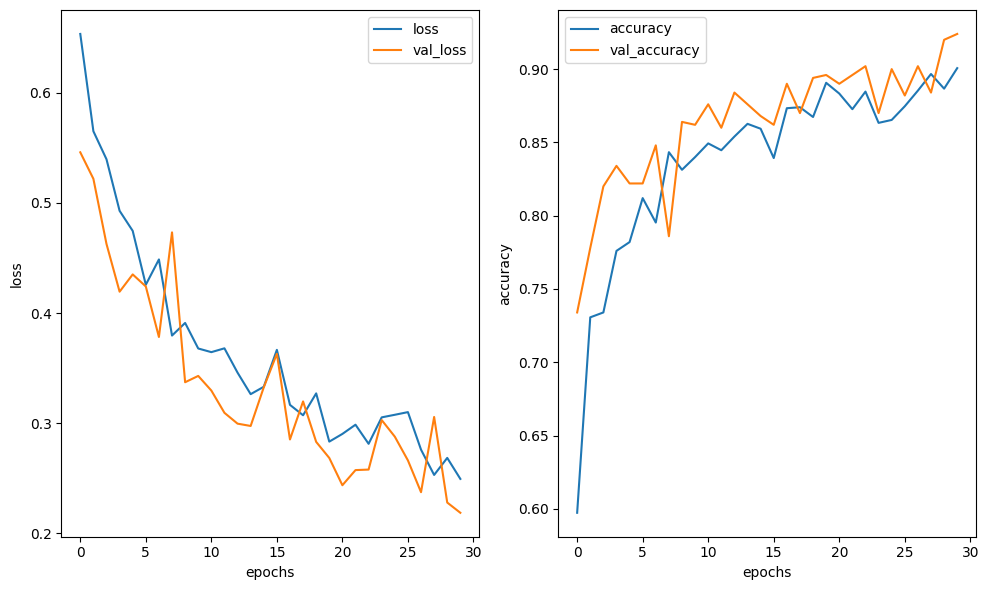

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

df_history = pd.DataFrame(history.history)

ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
sns.lineplot(df_history[['loss', 'val_loss']], ax=ax[0], dashes=False)

ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
sns.lineplot(df_history[['accuracy', 'val_accuracy']], ax=ax[1], dashes=False)

plt.tight_layout()
plt.show()

In [32]:
model.evaluate(val_data)

16/16 [==============================] - 1s 89ms/step - loss: 0.2188 - accuracy: 0.9240


[0.21876363456249237, 0.9240000247955322]

In [33]:
class_names = list(val_data.class_indices.keys())

class_names

['french_fries', 'fried_rice']

In [34]:
y_pred = np.round(model.predict(val_data))

y_pred.shape

16/16 [==============================] - 3s 141ms/step


(500, 1)

In [35]:
y_true = []

num_gen_calls = np.ceil(len(val_data.filenames) / 32).astype(np.int32)

for i in range(num_gen_calls):
  y_true.extend(val_data[i][1])

y_true = np.array(y_true)
y_true.shape

(500,)

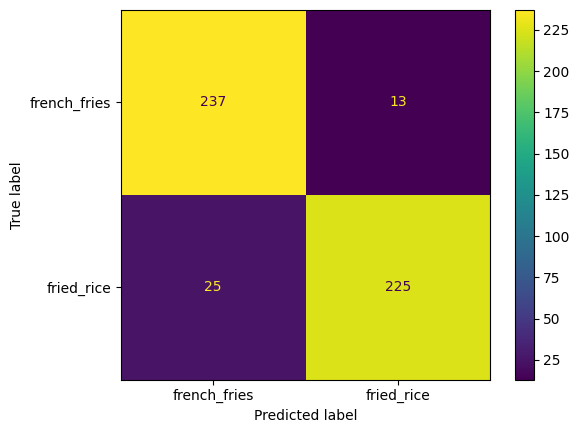

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names)

plt.show()

In [37]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True)).T

,precision,recall,f1-score,support
french_fries,0.904580,0.948,0.925781,250.000
fried_rice,0.945378,0.900,0.922131,250.000
accuracy,0.924000,0.924,0.924000,0.924
macro avg,0.924979,0.924,0.923956,500.000
weighted avg,0.924979,0.924,0.923956,500.000
